# Modelo

## Constantes

In [29]:
#NP = (110119 + 109164 + 111111) / 3 
NP = 110119 
A_TERR = 17.32 * NP / 3000

A_SOT = 8.66 ** 2                   #  Area del sotano (m2)
Q_MAX = 8                           #  Caudal maximo de la bomba (m^3/h)
D_H_MAX = 4                         #  Desnivel maximo de la bomba (m)
D_H_MIN = 1                         #  Desnivel minimo de la bomba (m)
H_SOT = 3.50                        #  Altura del sotano (m) 
V_SOT = H_SOT * A_SOT               #  Volumen del sotano (m3)

C_SAT = 0.90                        # Coeficiente de infiltracion con el suelo saturado (admin)
C_0 = 0.60                          # Coeficiente de infiltracion inicial (admin)

T_K = (1-NP/140000)                 # Tiempo caracteristico (h)


# EC 1
def f_derivada_volumen(q_ent, q_sal):
    return q_ent - q_sal


# EC 2
def f_caudal_entrada(c, i, a_terr):
    return c * i * a_terr           # admin * m/h * m2 = m3/h

# EC 3
def f_caudal_salida(q_max, d_h_max, d_h_min, d_h):
    argument = (d_h_max - d_h) / (d_h_max - d_h_min)
    if argument < 0: 
        raise ValueError("Argumento negativo en raiz cuadrada")
    # if d_h < d_h_min: return q_max
    return q_max * ((argument) ** 0.5)

# EC 4
def f_desnivel_d_h(h_s, h):
    return h_s - h

# EC 5
def f_altura_agua_h(v, a_sot):
    return v / a_sot

# EC 6
def f_derivada_coeficiente_infiltracion(v, v_sot, t_k, c_sat, c):
    if v < 0:
        return 0
    return (v/(v_sot * t_k)) * (c_sat - c)

## A.1
Discretizar la ec. 1 con el método de Euler, tomando $C$ = 1, $Q$ = 0. Correr el modelo para la precipitación de 60 min y verificar que el volumen de agua almacenado en el sótano coincida con el volumen de lluvia.

In [35]:
INTENSITY = 85.0 / 1000  # m/h
DURATION = 1  # h
INFILTRATION = 1  # a-dimensional
Q_SAL = 0  # m3/h

def d_volume(t, u):
    q_ent = f_caudal_entrada(INFILTRATION, INTENSITY, A_TERR)  # m3/h
    q_sal = Q_SAL  # m3/h

    return f_derivada_volumen(q_ent, q_sal)  # m3/h


delta_time = 1 / 60  # h

water_volume = 0  # m3
time = 0  # h

volumes = []
times = []

while time <= DURATION:
    q_ent = f_caudal_entrada(INFILTRATION, INTENSITY, A_TERR)  # m3/h
    water_volume = water_volume + delta_time * d_volume(time, water_volume)
    time += delta_time
    volumes.append(water_volume)
    times.append(time)

print(f"Final volume: {round(water_volume, 2)} m3")

Final volume: 54.04 m3


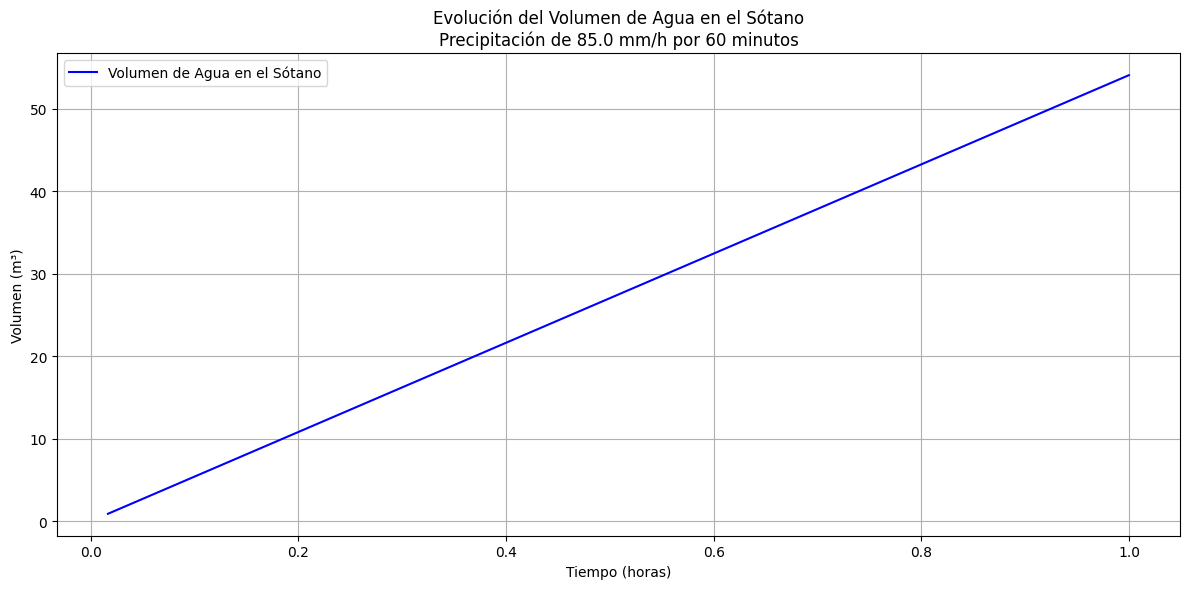

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(times, volumes, label='Volumen de Agua en el Sótano', color='blue')
# plt.axhline(y=V_SOT, color='r', linestyle='--', label='Volumen Máximo del Sótano')
plt.xlabel('Tiempo (horas)')
plt.ylabel('Volumen (m³)')
plt.title(f'Evolución del Volumen de Agua en el Sótano\nPrecipitación de {INTENSITY*1000} mm/h por {DURATION*60} minutos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## A.2

Discretizar las ec. 1 y ec. 6 con el método de Euler, considerando $C$ y $Q_{sal}$ variables. Correr
el modelo para todas las duraciónes / intensidades de precipitación, un lapso de tiempo
suficiente como para que el sótano se vacíe

In [38]:
storms_min_mm = [       # min, mm/h
    (5, 241.4),
    (10, 190.7),
    (15, 162.6),
    (30, 119.6),
    (60, 85.0),
    (180, 41.7),
    (360, 26.4),
    (720, 16.7),
    (1440, 10.9),
    (4320, 5.2),
]

storms = [(duration/60, intensity/1000) for duration, intensity in storms_min_mm] # h, m/h

storms_history = []

def d_volume(time, water_volume, infiltration, intensity):
    terrain_area = A_TERR

    max_flow = Q_MAX
    max_height_variation = D_H_MAX
    min_height_variation = D_H_MIN
    
    sotane_height = H_SOT
    
    sotane_area = A_SOT
    water_height = f_altura_agua_h(water_volume, sotane_area)

    heigth_variation = f_desnivel_d_h(sotane_height, water_height)

    entry_flow = f_caudal_entrada(infiltration, intensity, terrain_area)

    # if water_height > 0:
    #     exit_flow = f_caudal_salida(max_flow, max_height_variation, min_height_variation, heigth_variation)
    # else:
    #     exit_flow = 0
    exit_flow = f_caudal_salida(max_flow, max_height_variation, min_height_variation, heigth_variation)

    return f_derivada_volumen(entry_flow, exit_flow)

def d_infiltration(t, volume, infiltration):

    sotane_volume = V_SOT

    caracteristic_time = T_K
    saturation_infiltration = C_SAT

    return f_derivada_coeficiente_infiltracion(volume, sotane_volume, caracteristic_time, saturation_infiltration, infiltration)

for storm_duration, storm_intensity in storms:

    print(f"Starting storm with {storm_intensity*1000} mm/h for {storm_duration*60} min")

    volumes = []
    infiltrations = []
    entry_flows = []
    exit_flows = []

    time = 0
    
    volume = 0
    volumes.append(volume)

    infiltration = C_0
    infiltrations.append(infiltration)

    d_time = storm_duration / 100

    total_rainfall_volume = 0

    # Fase de lluvia
    while time < storm_duration:
        dv = d_time * d_volume(time, volume, infiltration, storm_intensity)
        volume = volume + dv
        volume = max(volume, 0)
        total_rainfall_volume += d_time * storm_intensity * A_TERR
        infiltration = infiltration + d_time * d_infiltration(time, volume, infiltration)
        volumes.append(volume)
        infiltrations.append(infiltration)
        entry_flows.append(f_caudal_entrada(infiltration, storm_intensity, A_TERR))
        exit_flows.append(f_caudal_salida(Q_MAX, D_H_MAX, D_H_MIN, f_desnivel_d_h(H_SOT, f_altura_agua_h(volume, A_SOT))))
        time += d_time

    print(f"Storm finish and sotane has {round(volume,2)} m3")
    print(f"Total rainfall volume: {round(total_rainfall_volume,2)} m3")
    print(f"Difference between rainfall volume and stored volume: {round(total_rainfall_volume - volume, 2)} m3")

    # Fase de vaciamiento del sotano
    end_time = time + storm_duration * 2  # Duración total permitida para vaciamiento
    while volume > 0 and time < end_time:
        dv = d_time * d_volume(time, volume, infiltration, 0)
        volume = volume + dv
        volume = max(volume, 0)  # Asegura que el volumen no sea negativo
        infiltration = infiltration + d_time * d_infiltration(time, volume, infiltration)
        volumes.append(volume)
        infiltrations.append(infiltration)
        entry_flows.append(0)
        exit_flows.append(f_caudal_salida(Q_MAX, D_H_MAX, D_H_MIN, f_desnivel_d_h(H_SOT, f_altura_agua_h(volume, A_SOT))))
        time += d_time

    avg_entry_flow = sum(entry_flows) / len(entry_flows)
    avg_exit_flow = sum(exit_flows) / len(exit_flows)

    print(f"Average entry flow during storm: {round(avg_entry_flow, 2)} m3/h")
    print(f"Average exit flow during storm: {round(avg_exit_flow, 2)} m3/h")
    print(f"Empyting sotane after {round(time*60,2)} min")
    print(f"Final infiltration coefficient: {round(infiltration, 4)}")
    print("")

    storms_history.append((storm_duration, storm_intensity, volumes, infiltrations, d_time))


Starting storm with 241.4 mm/h for 5.0 min
Storm finish and sotane has 7.4 m3
Total rainfall volume: 12.79 m3
Difference between rainfall volume and stored volume: 5.39 m3
Average entry flow during storm: 30.62 m3/h
Average exit flow during storm: 3.52 m3/h
Empyting sotane after 15.05 min
Final infiltration coefficient: 0.6079

Starting storm with 190.7 mm/h for 10.0 min
Storm finish and sotane has 11.57 m3
Total rainfall volume: 20.21 m3
Difference between rainfall volume and stored volume: 8.63 m3
Average entry flow during storm: 24.24 m3/h
Average exit flow during storm: 3.64 m3/h
Empyting sotane after 30.1 min
Final infiltration coefficient: 0.6239

Starting storm with 162.6 mm/h for 15.0 min
Storm finish and sotane has 14.7 m3
Total rainfall volume: 25.84 m3
Difference between rainfall volume and stored volume: 11.14 m3
Average entry flow during storm: 20.72 m3/h
Average exit flow during storm: 3.74 m3/h
Empyting sotane after 45.15 min
Final infiltration coefficient: 0.6434

Start

In [39]:
# import matplotlib.pyplot as plt

# for storm_duration, storm_intensity, volumes, infiltrations, d_time in storms_history:
#         times = [i*d_time for i in range(len(volumes))]
#         if storm_duration >= 1:
#                 plt.plot(times, volumes, label=f"Volume {storm_intensity*1000} mm/h for {storm_duration} hs")
#         else:
#                 plt.plot(times, volumes, label=f"Volume {storm_intensity*1000} mm/h for {storm_duration*60} min")

# plt.axhline(y=V_SOT, color='r', linestyle='-', label="Max volume")
# plt.xlabel("Time (h)")
# plt.ylabel("Volume (m3)")
# plt.legend()
# plt.show()

# for storm_duration, storm_intensity, volumes, infiltrations, d_time in storms_history:
#         times = [i*d_time for i in range(len(infiltrations))]
#         if storm_duration >= 1:
#                 plt.plot(times, infiltrations, label=f"Infiltration {storm_intensity*1000} mm/h for {storm_duration} hs")
#         else:
#                 plt.plot(times, infiltrations, label=f"Infiltration {storm_intensity*1000} mm/h for {storm_duration*60} min")

# plt.axhline(y=C_SAT, color='r', linestyle='-', label="Max infiltration")
# plt.axhline(y=C_0, color='g', linestyle='-', label="Min infiltration")
# plt.xlabel("Time (h)")
# plt.ylabel("Infiltration")
# plt.legend()
# plt.show()

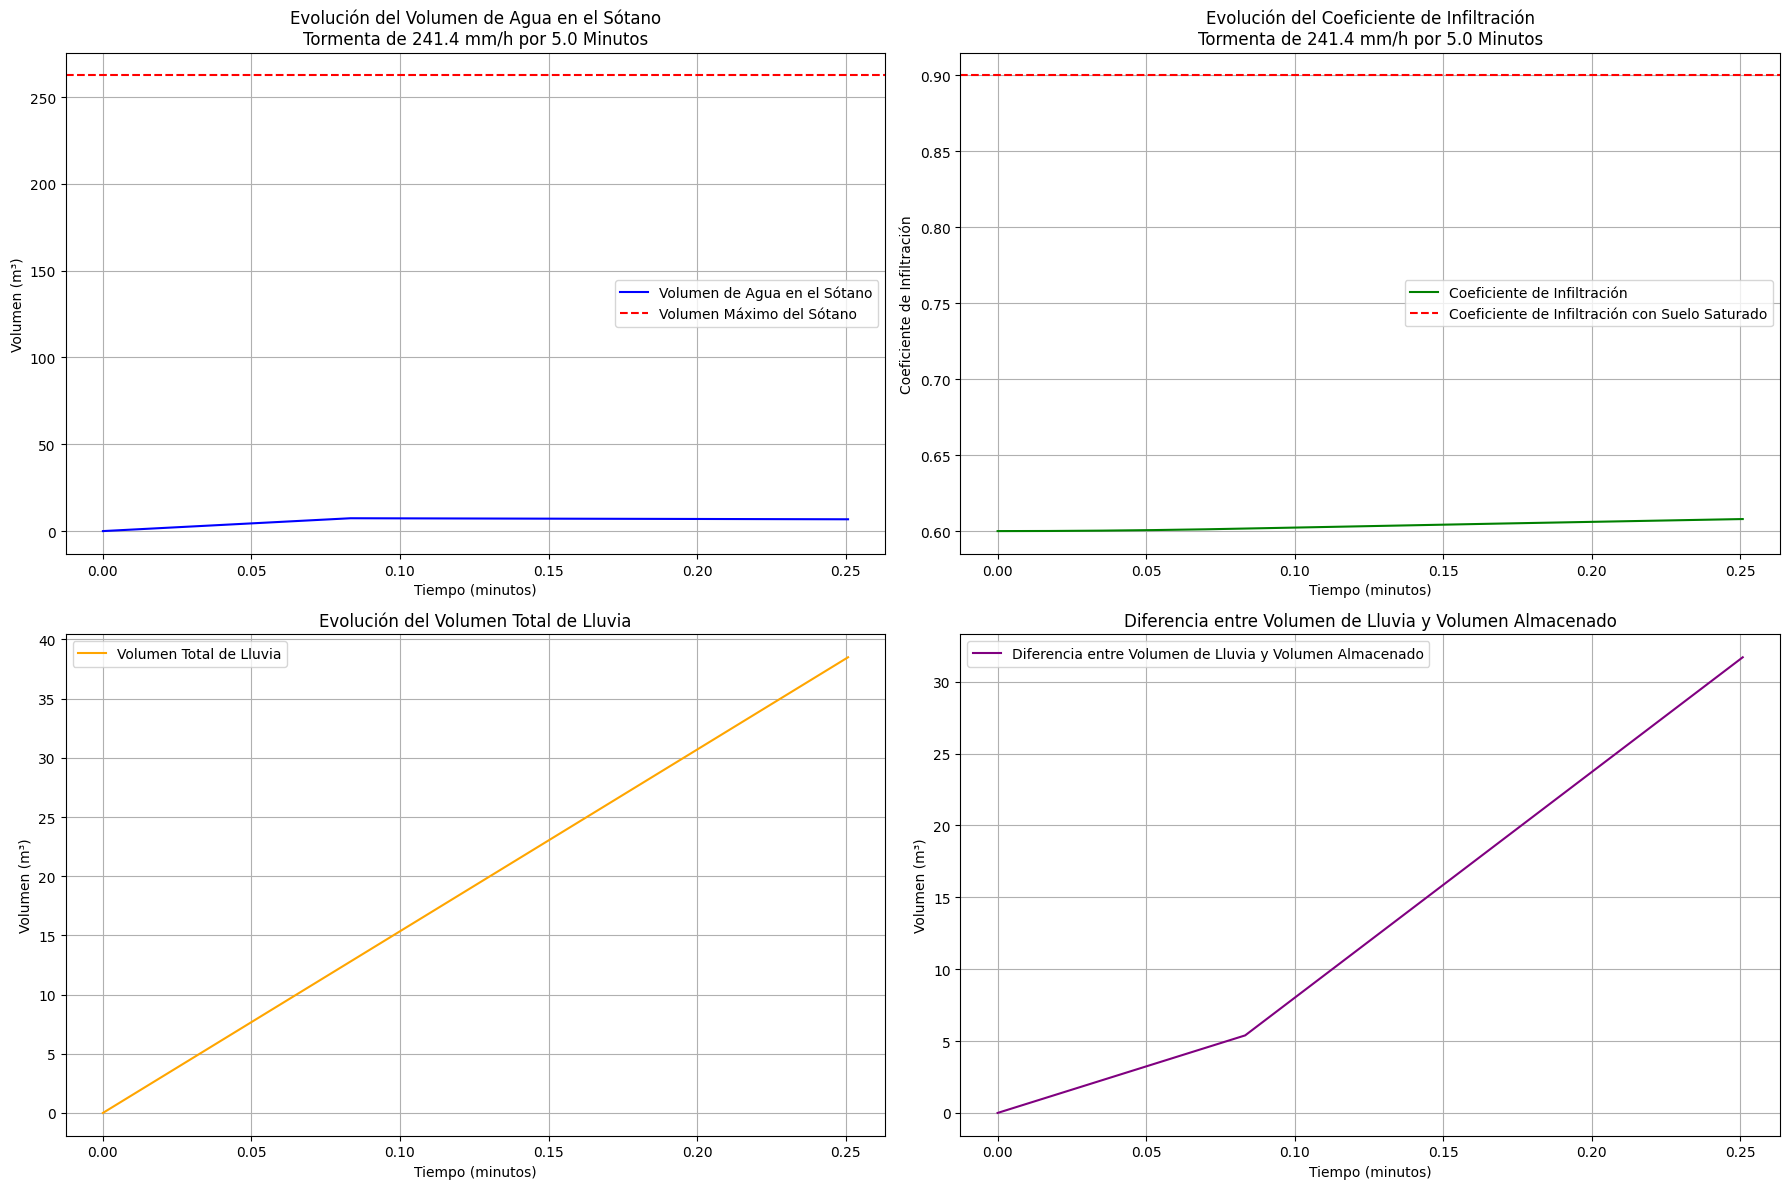

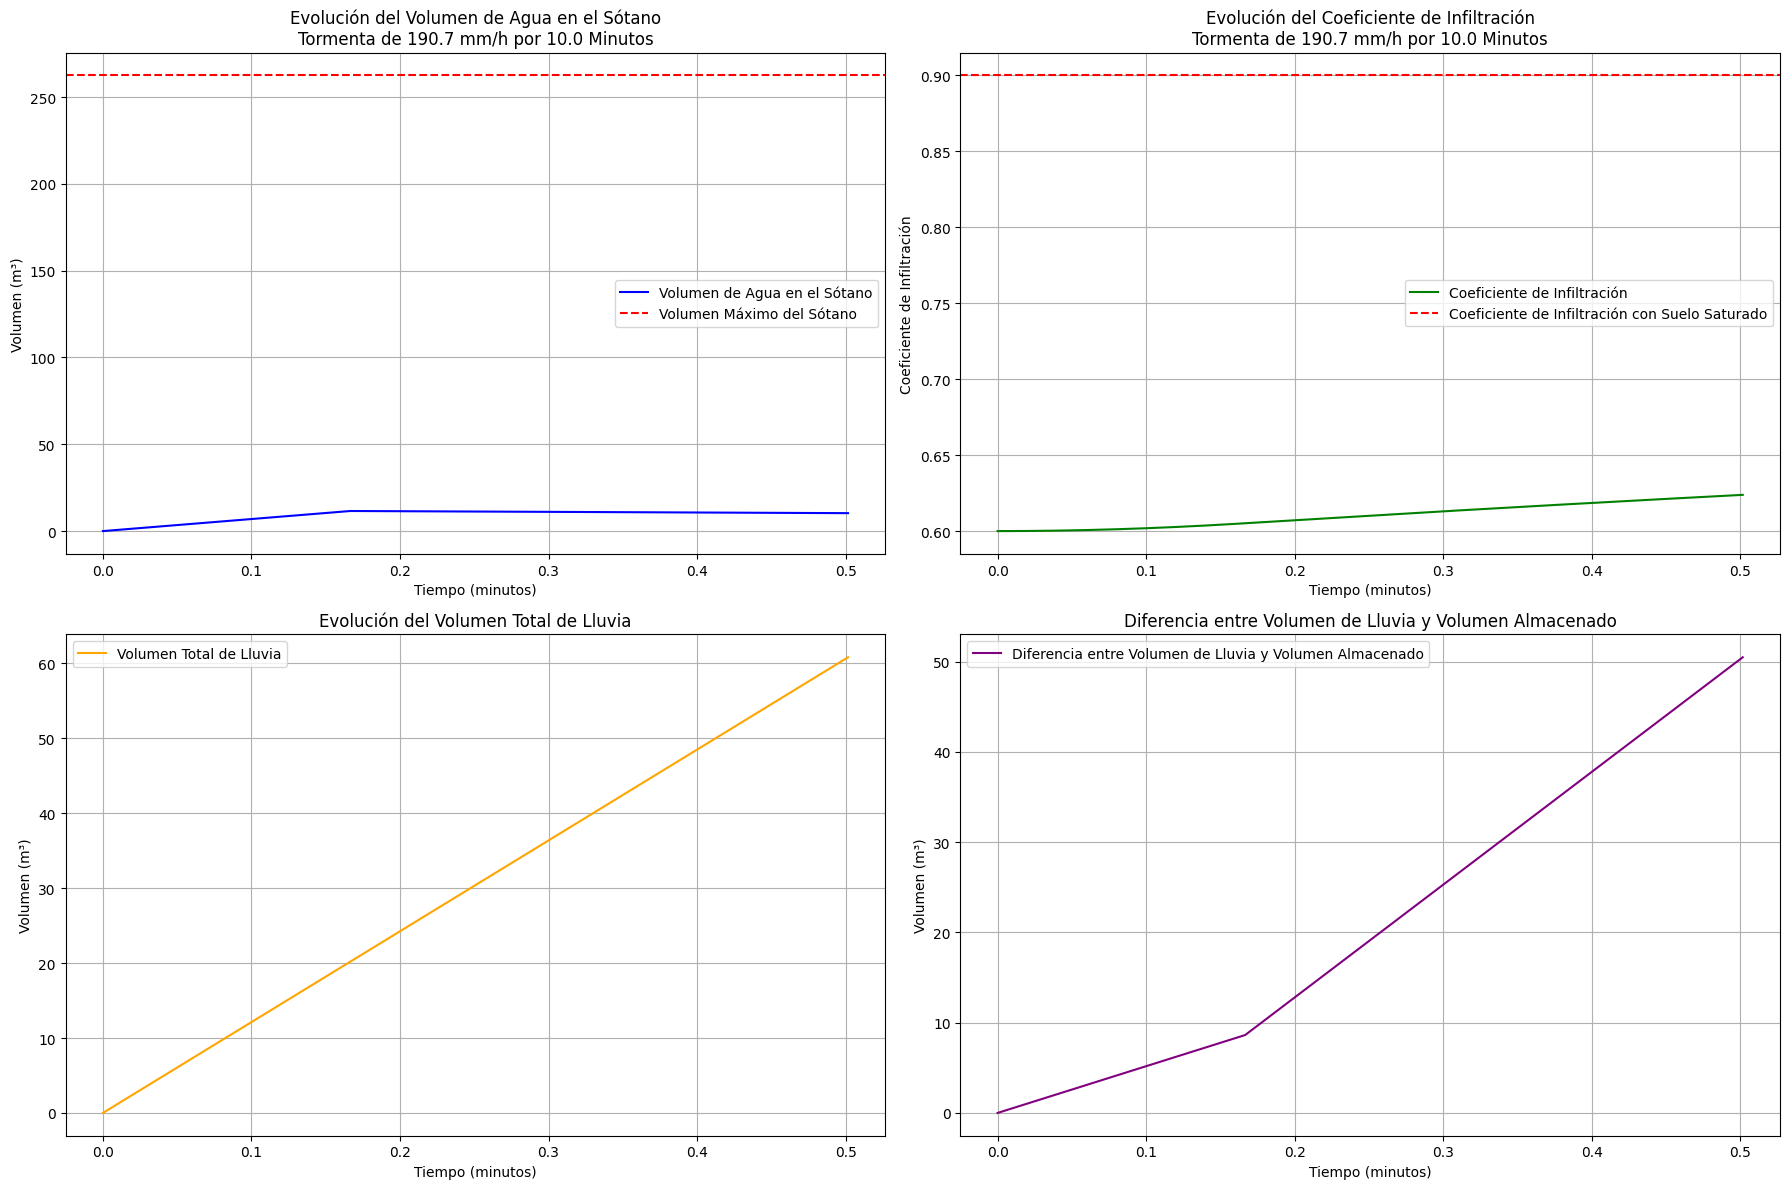

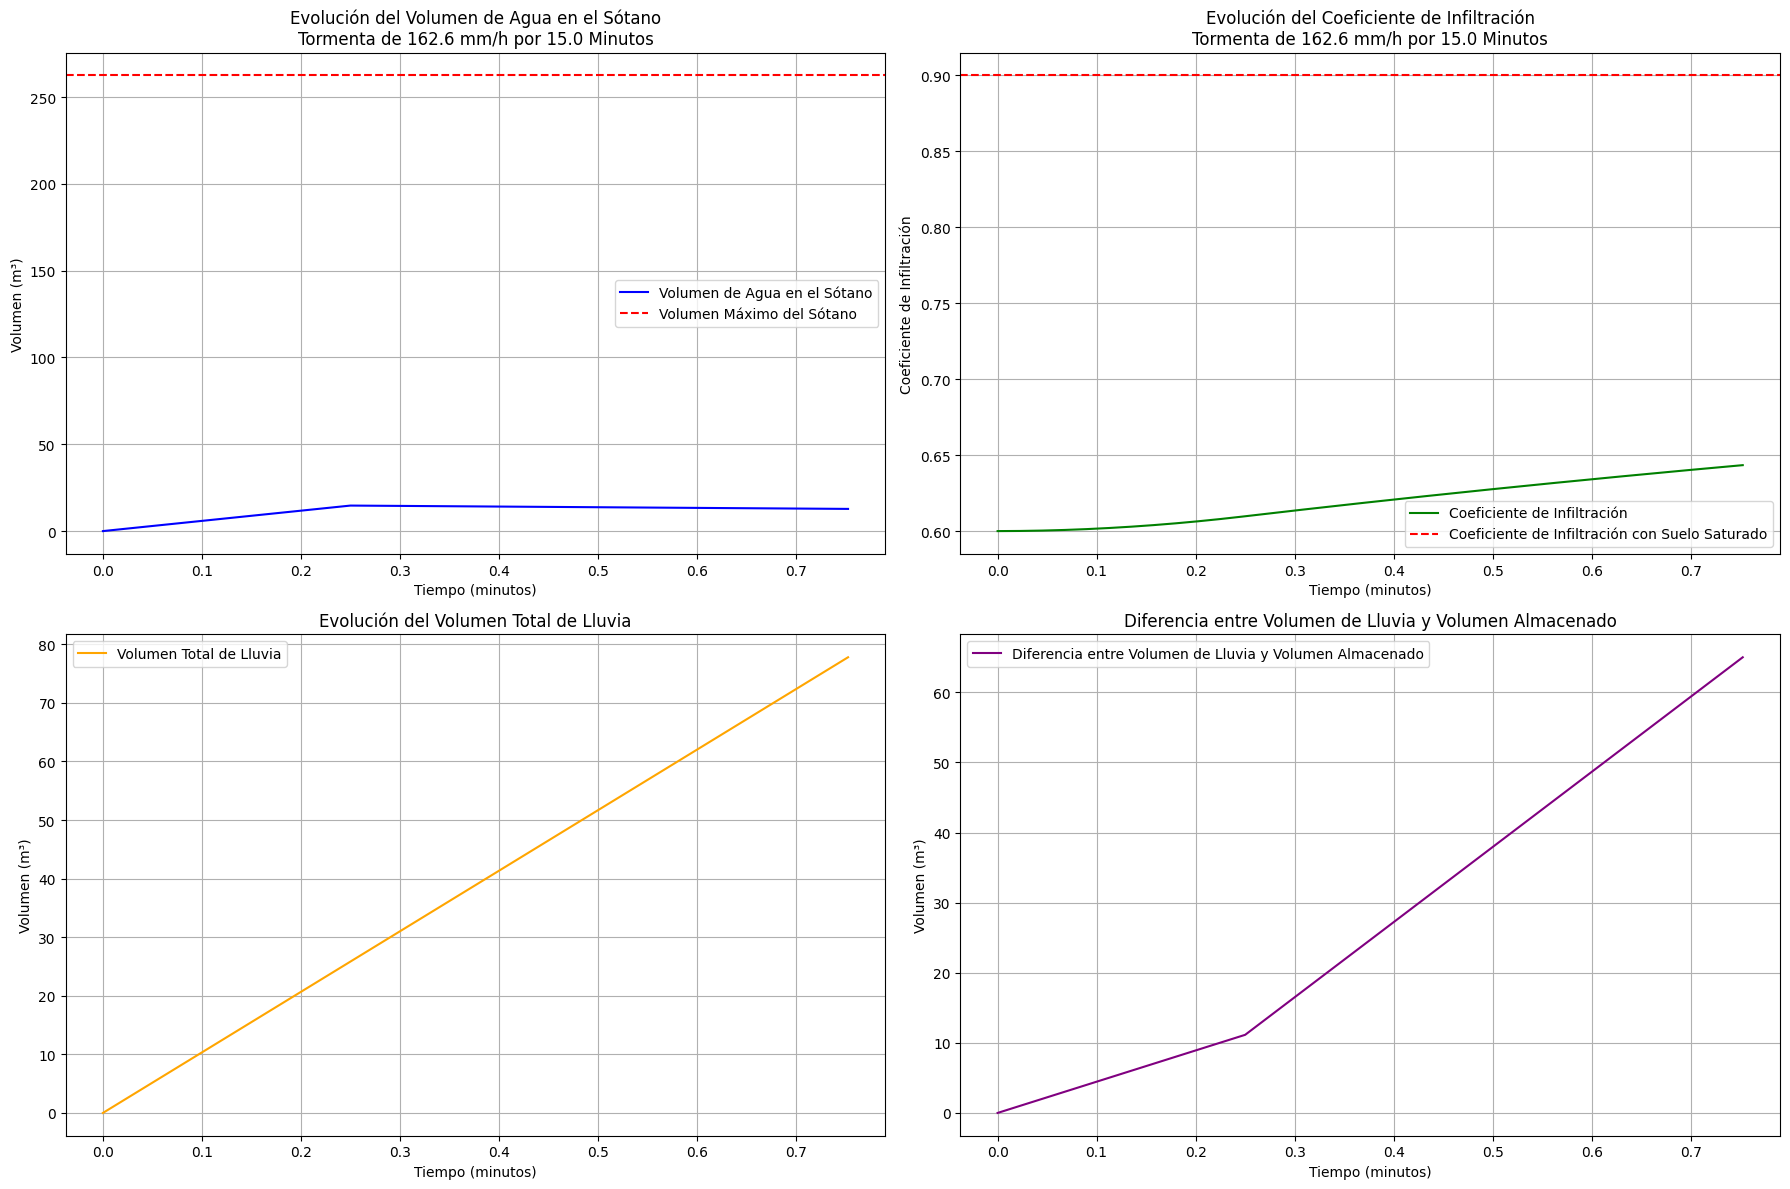

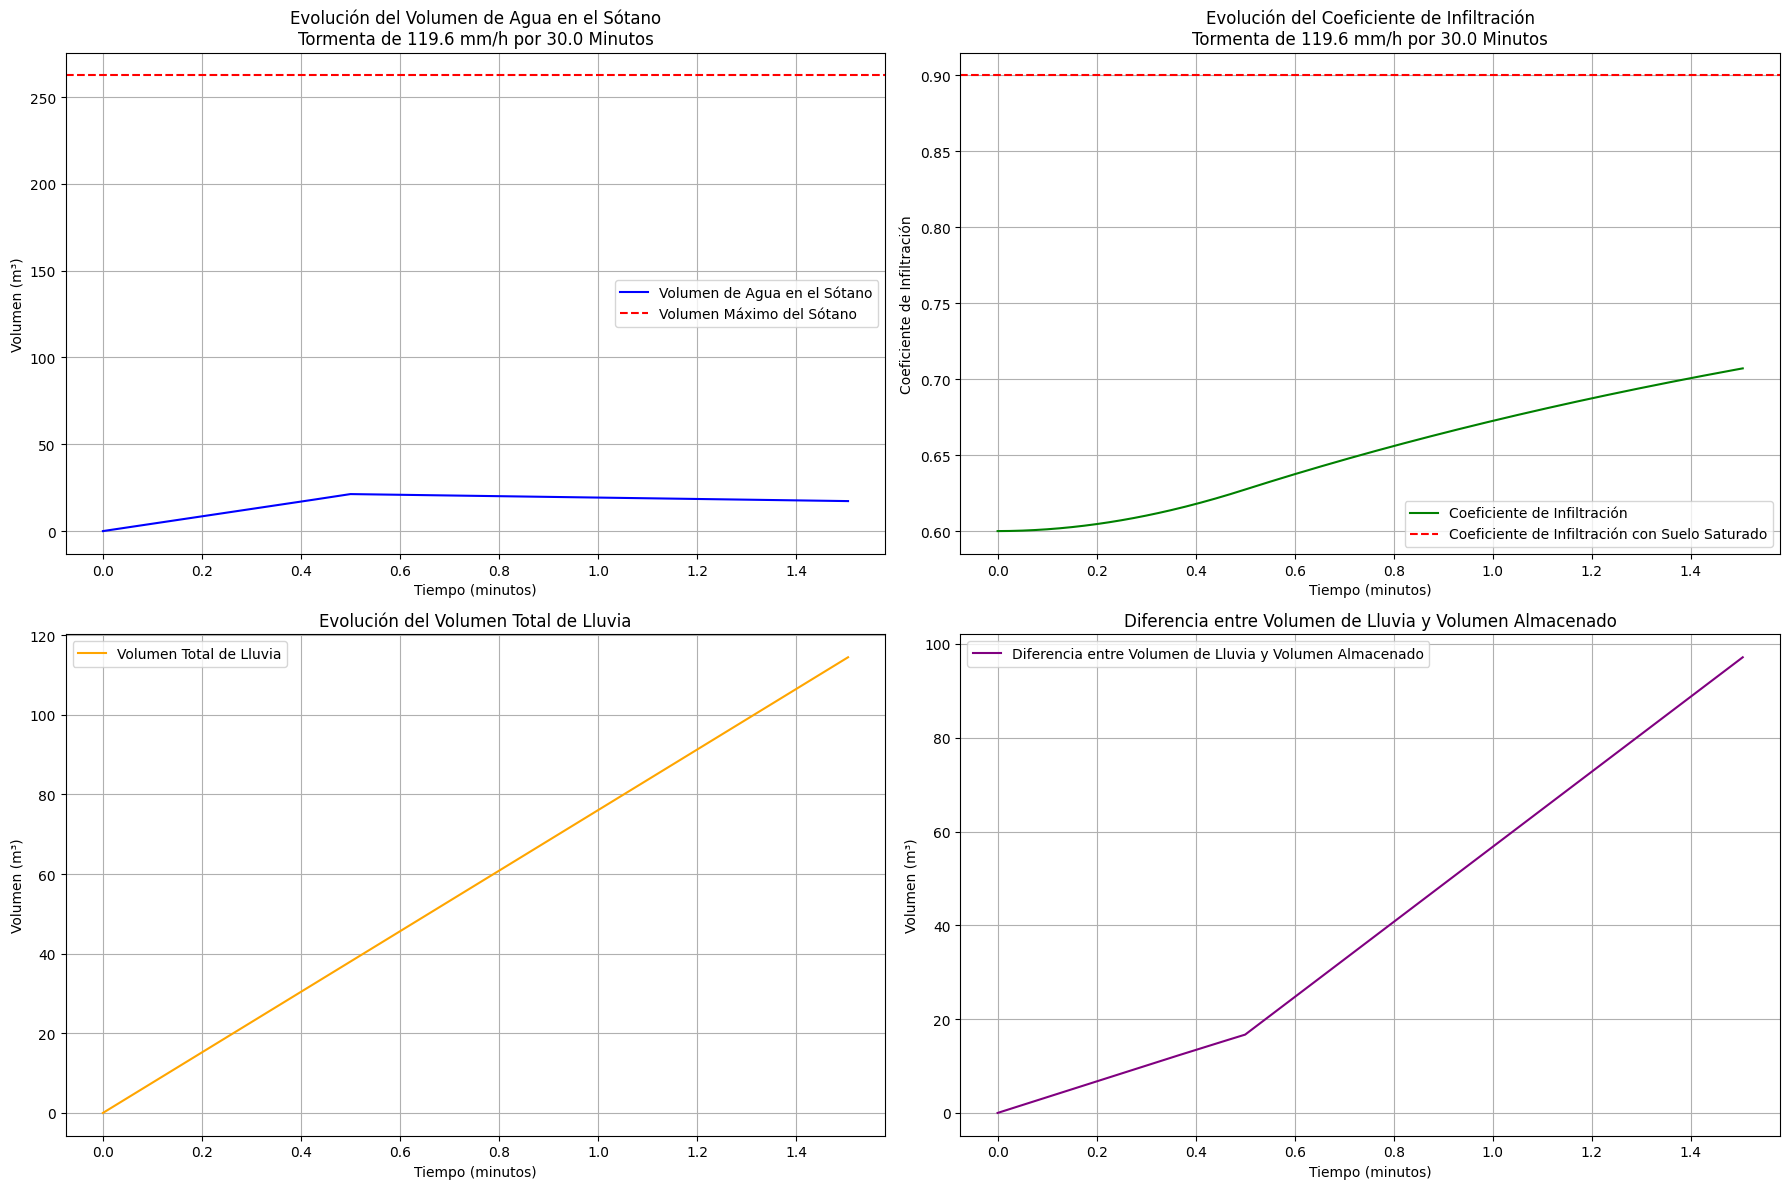

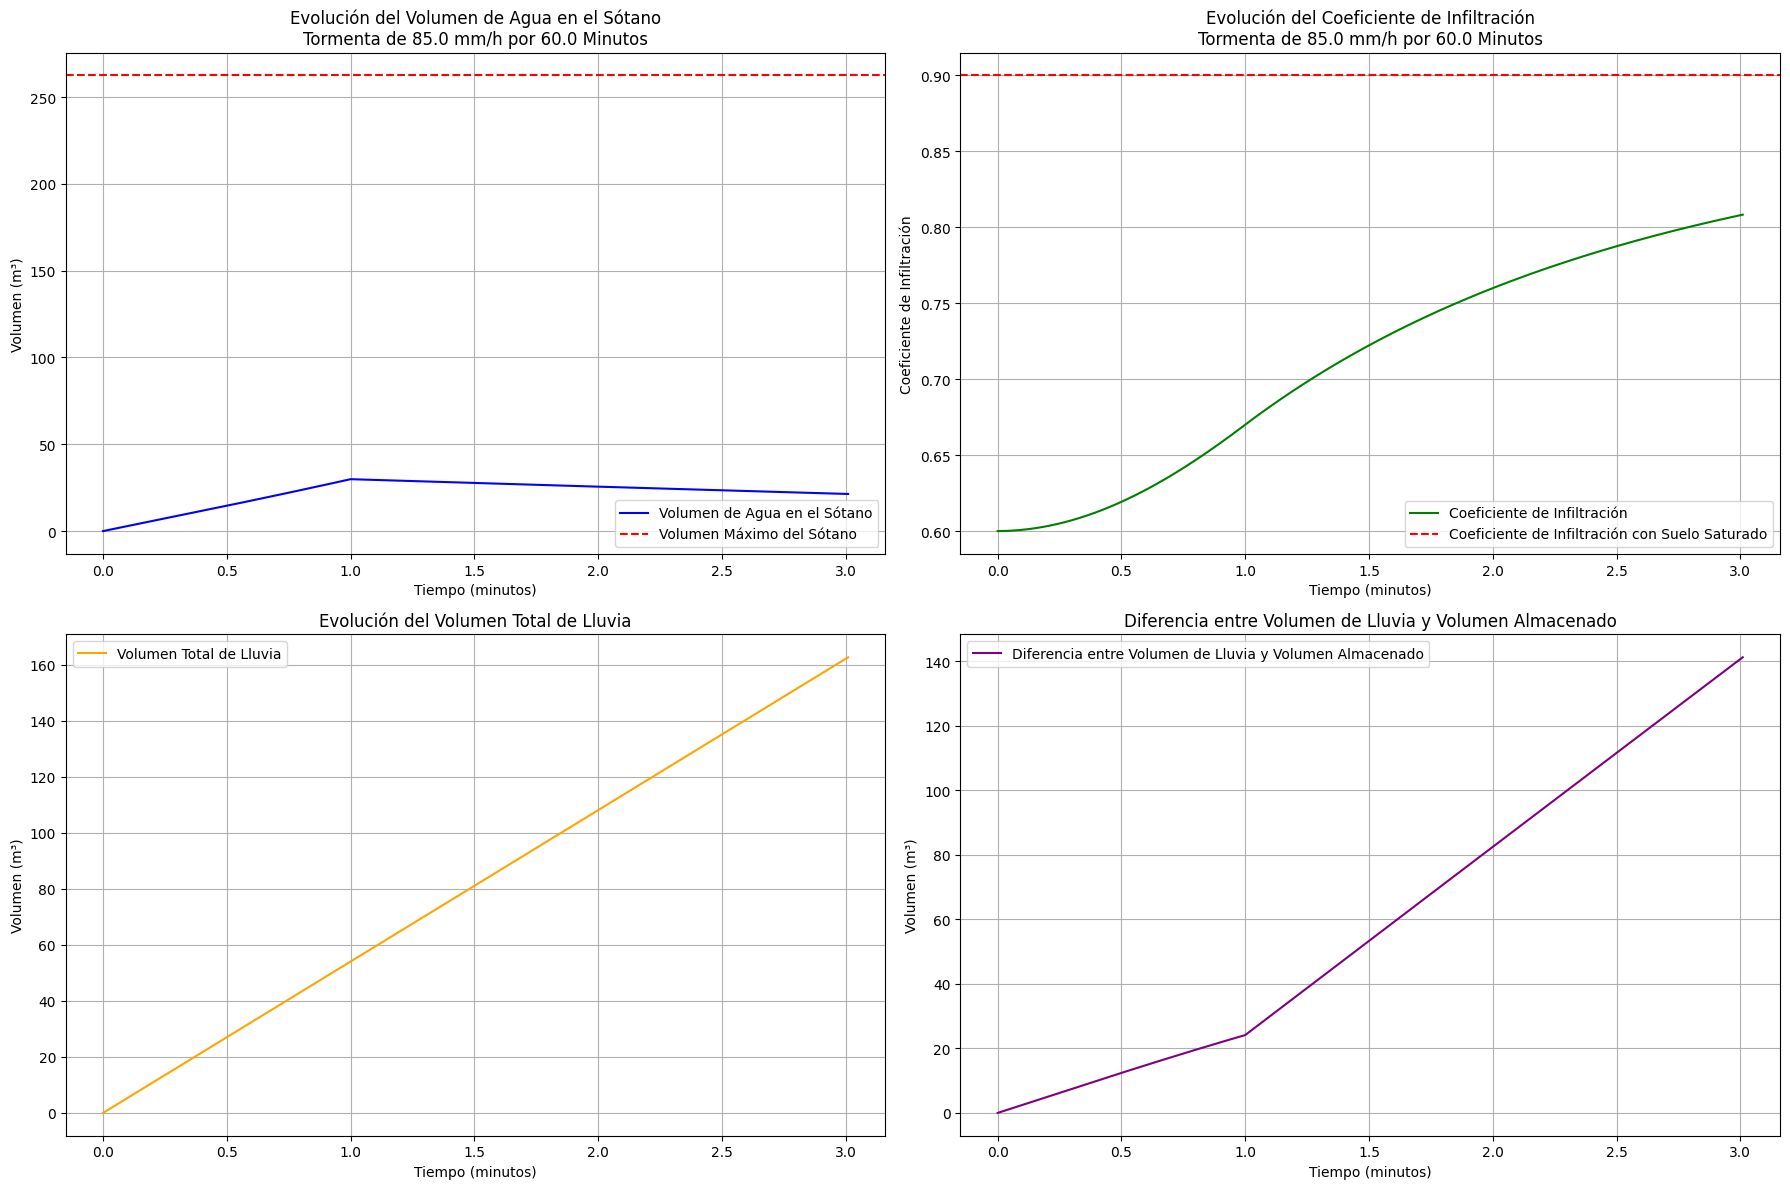

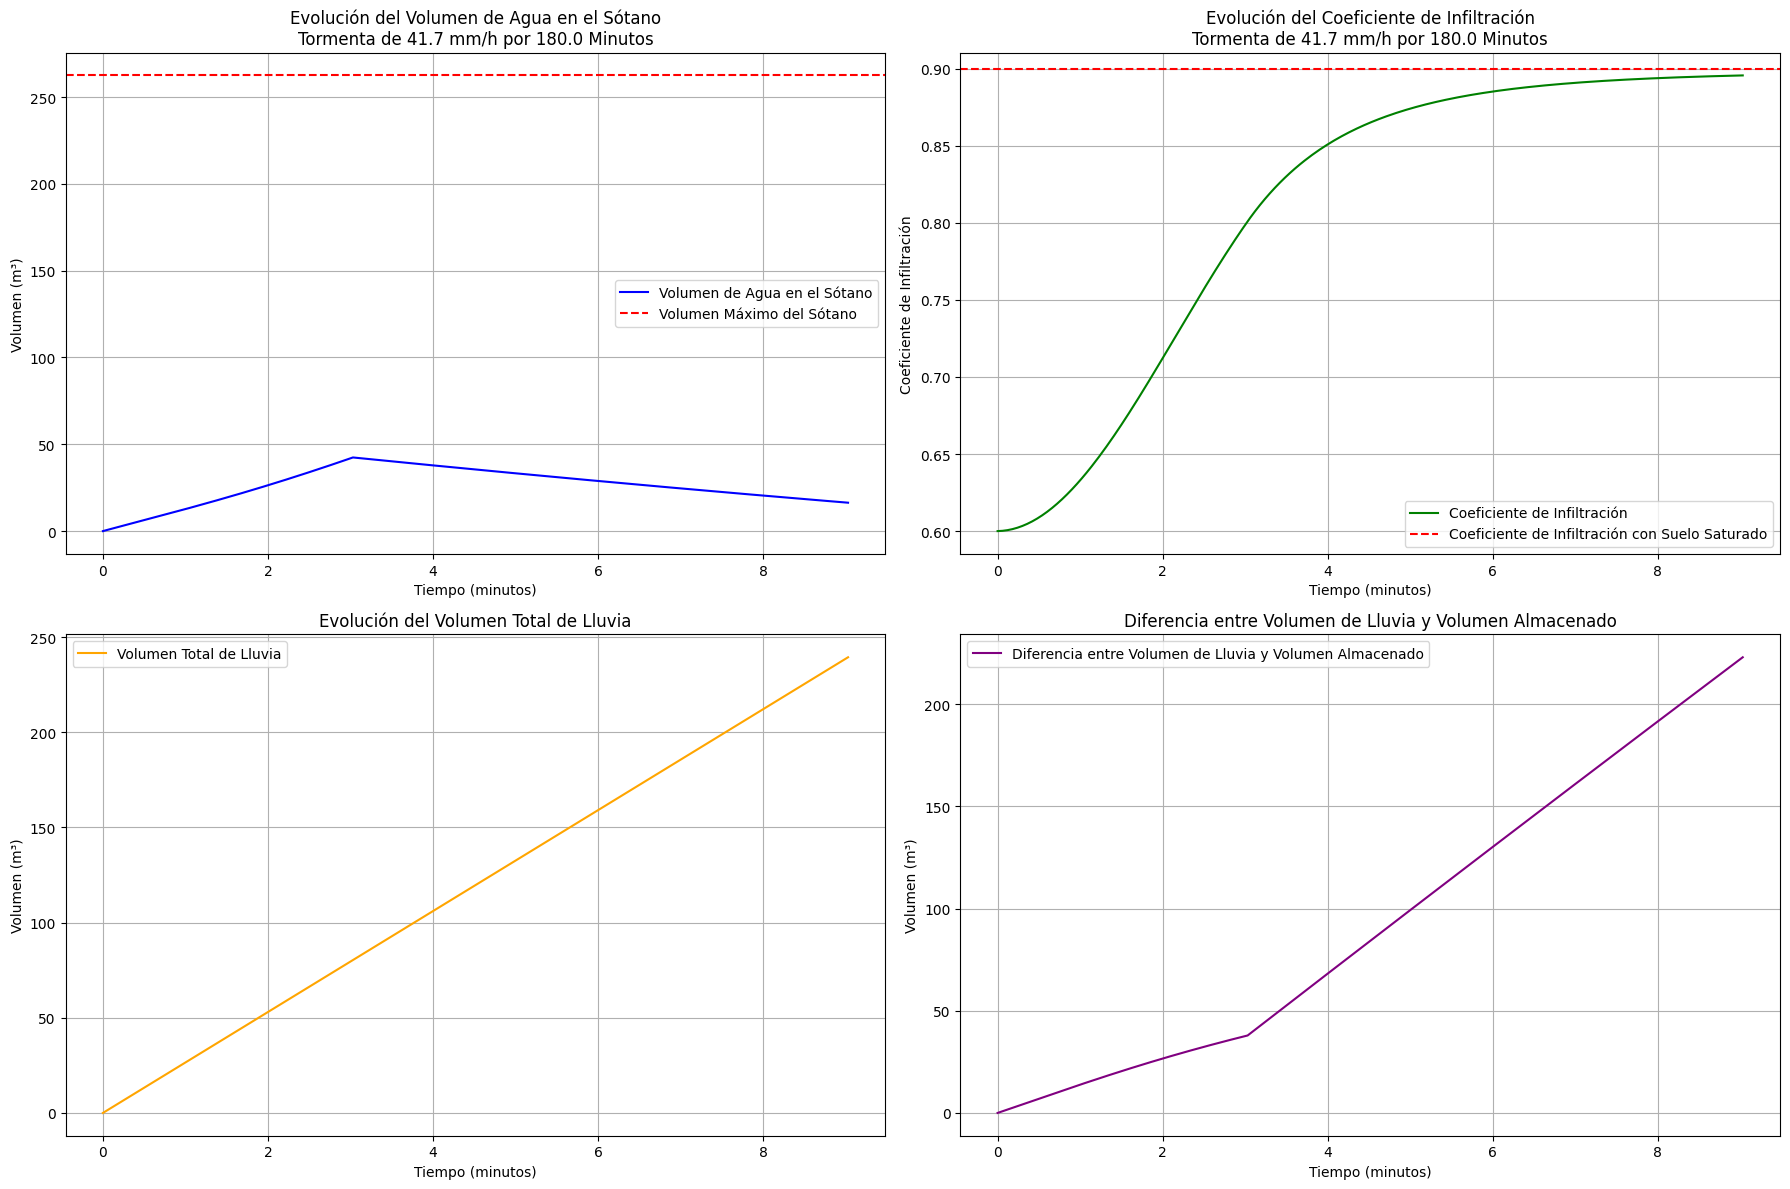

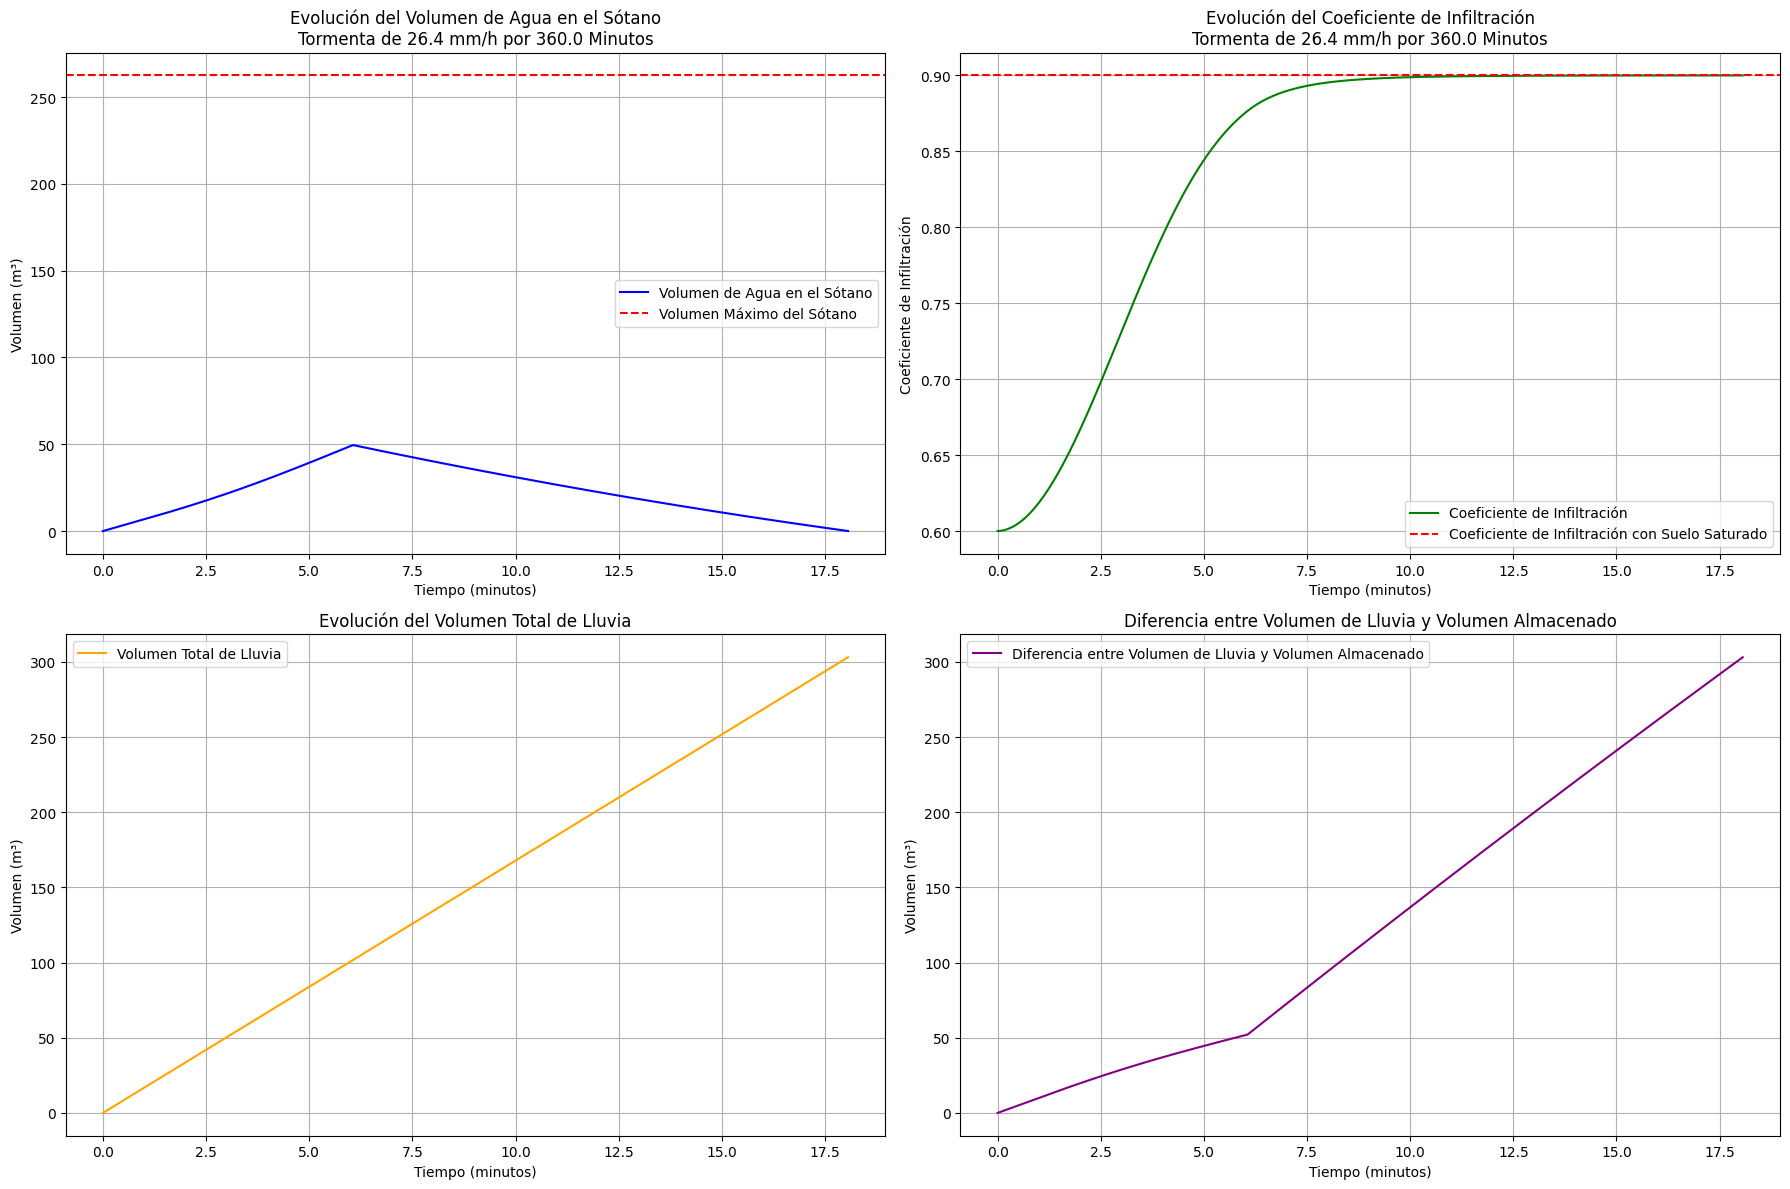

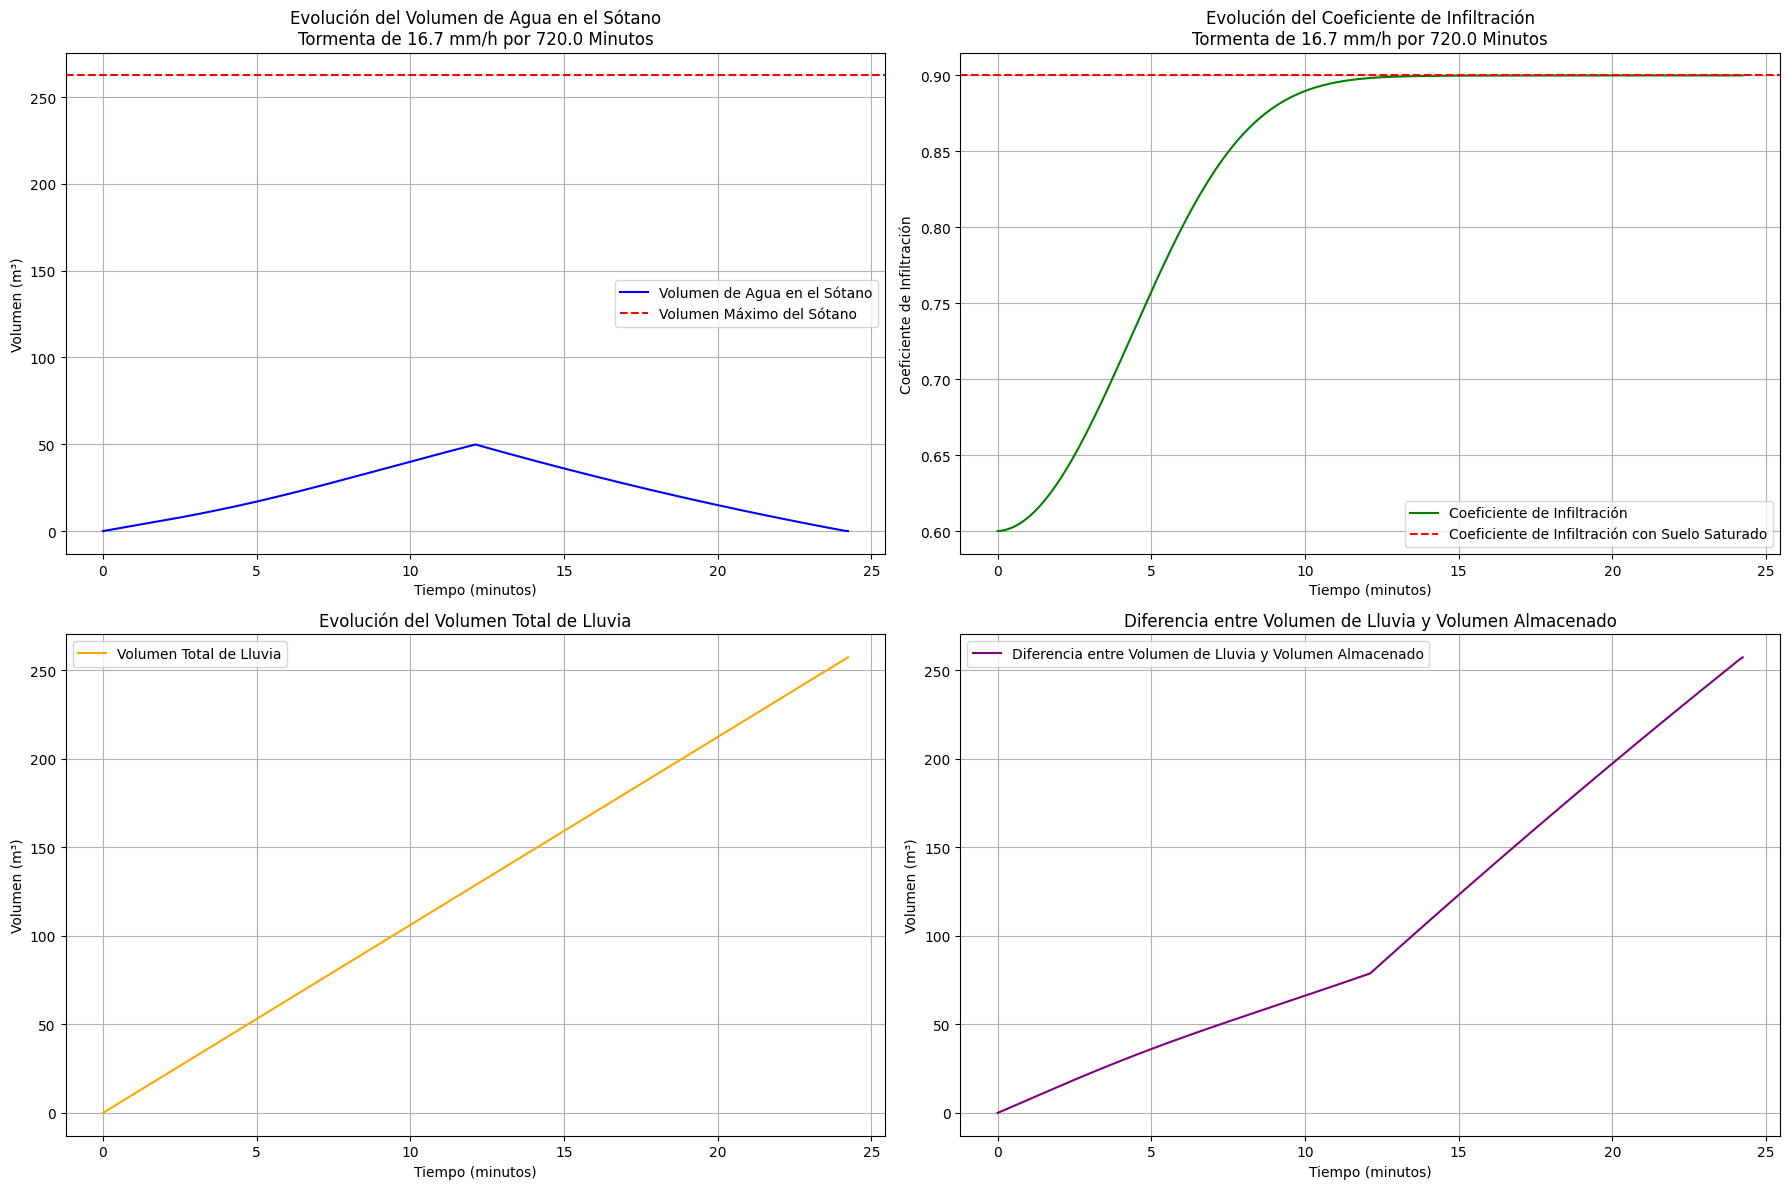

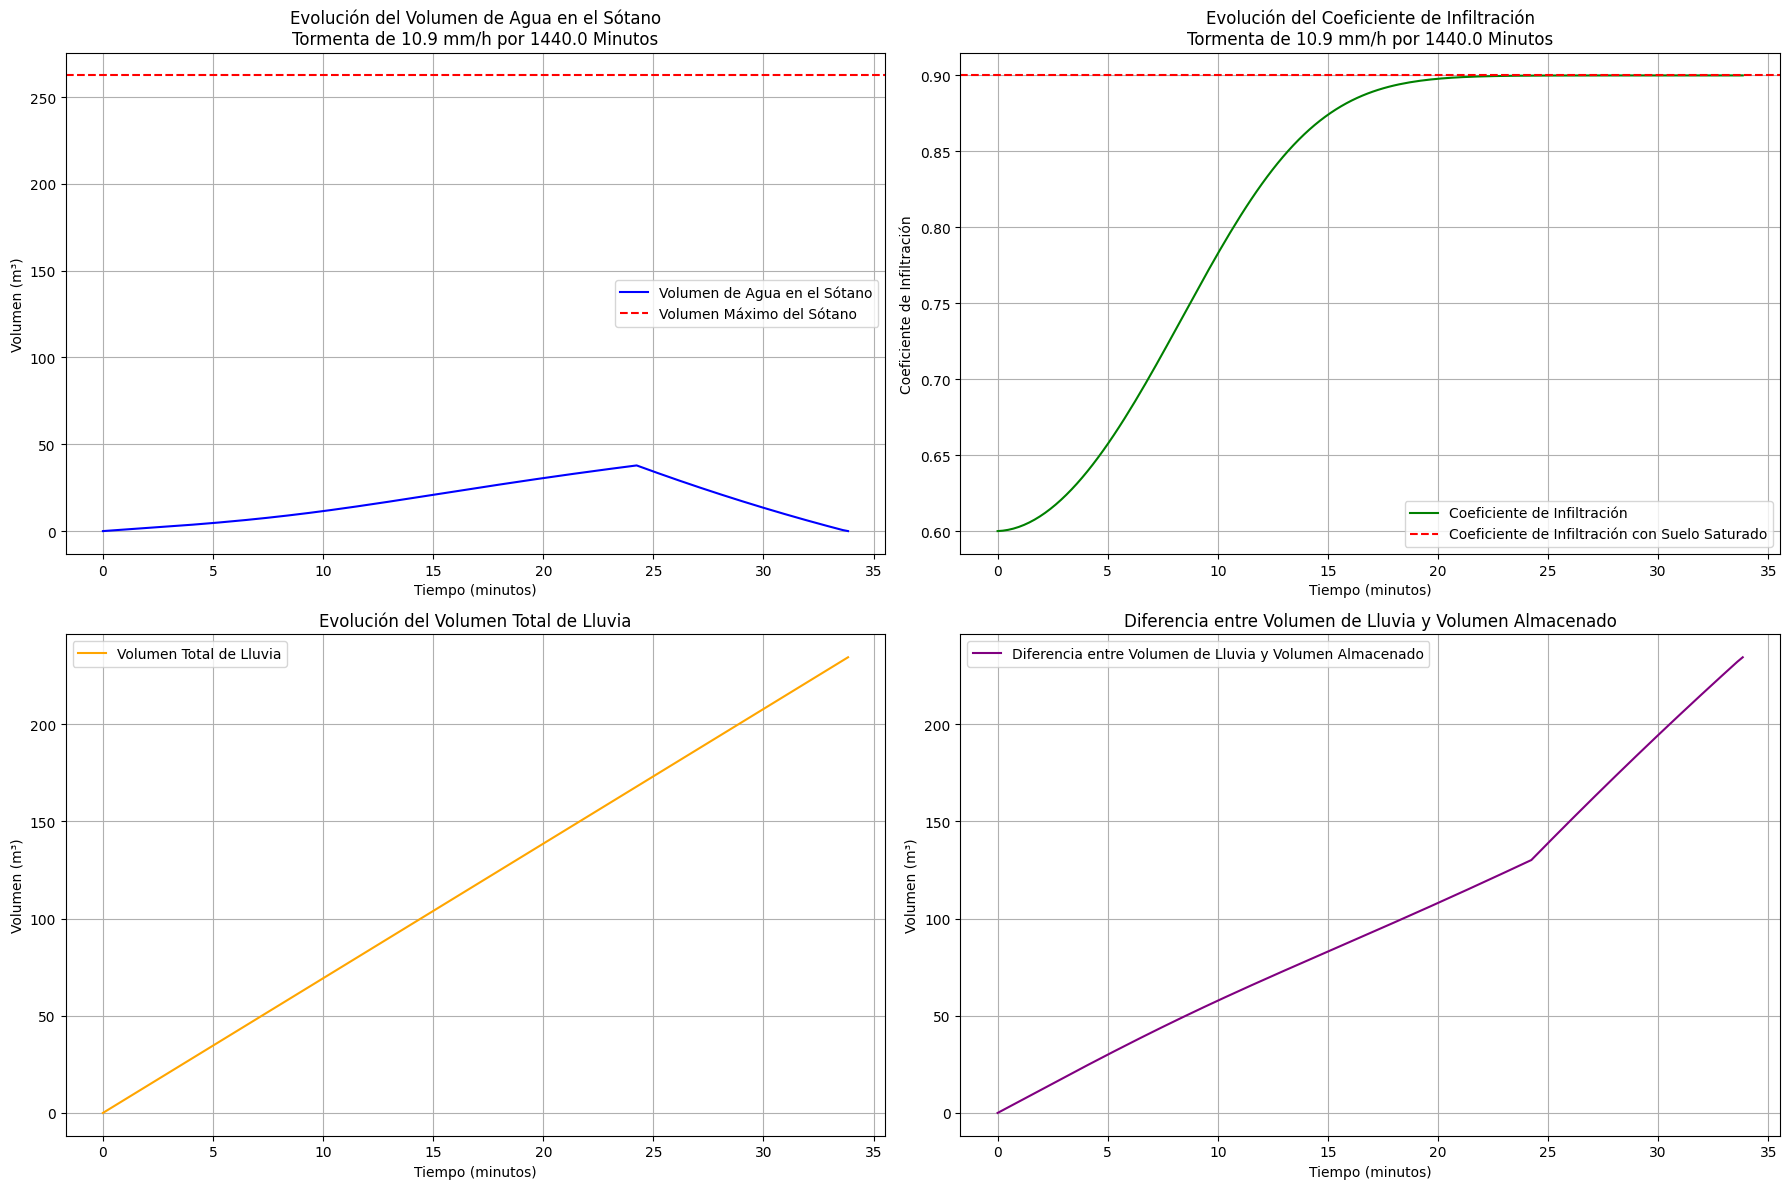

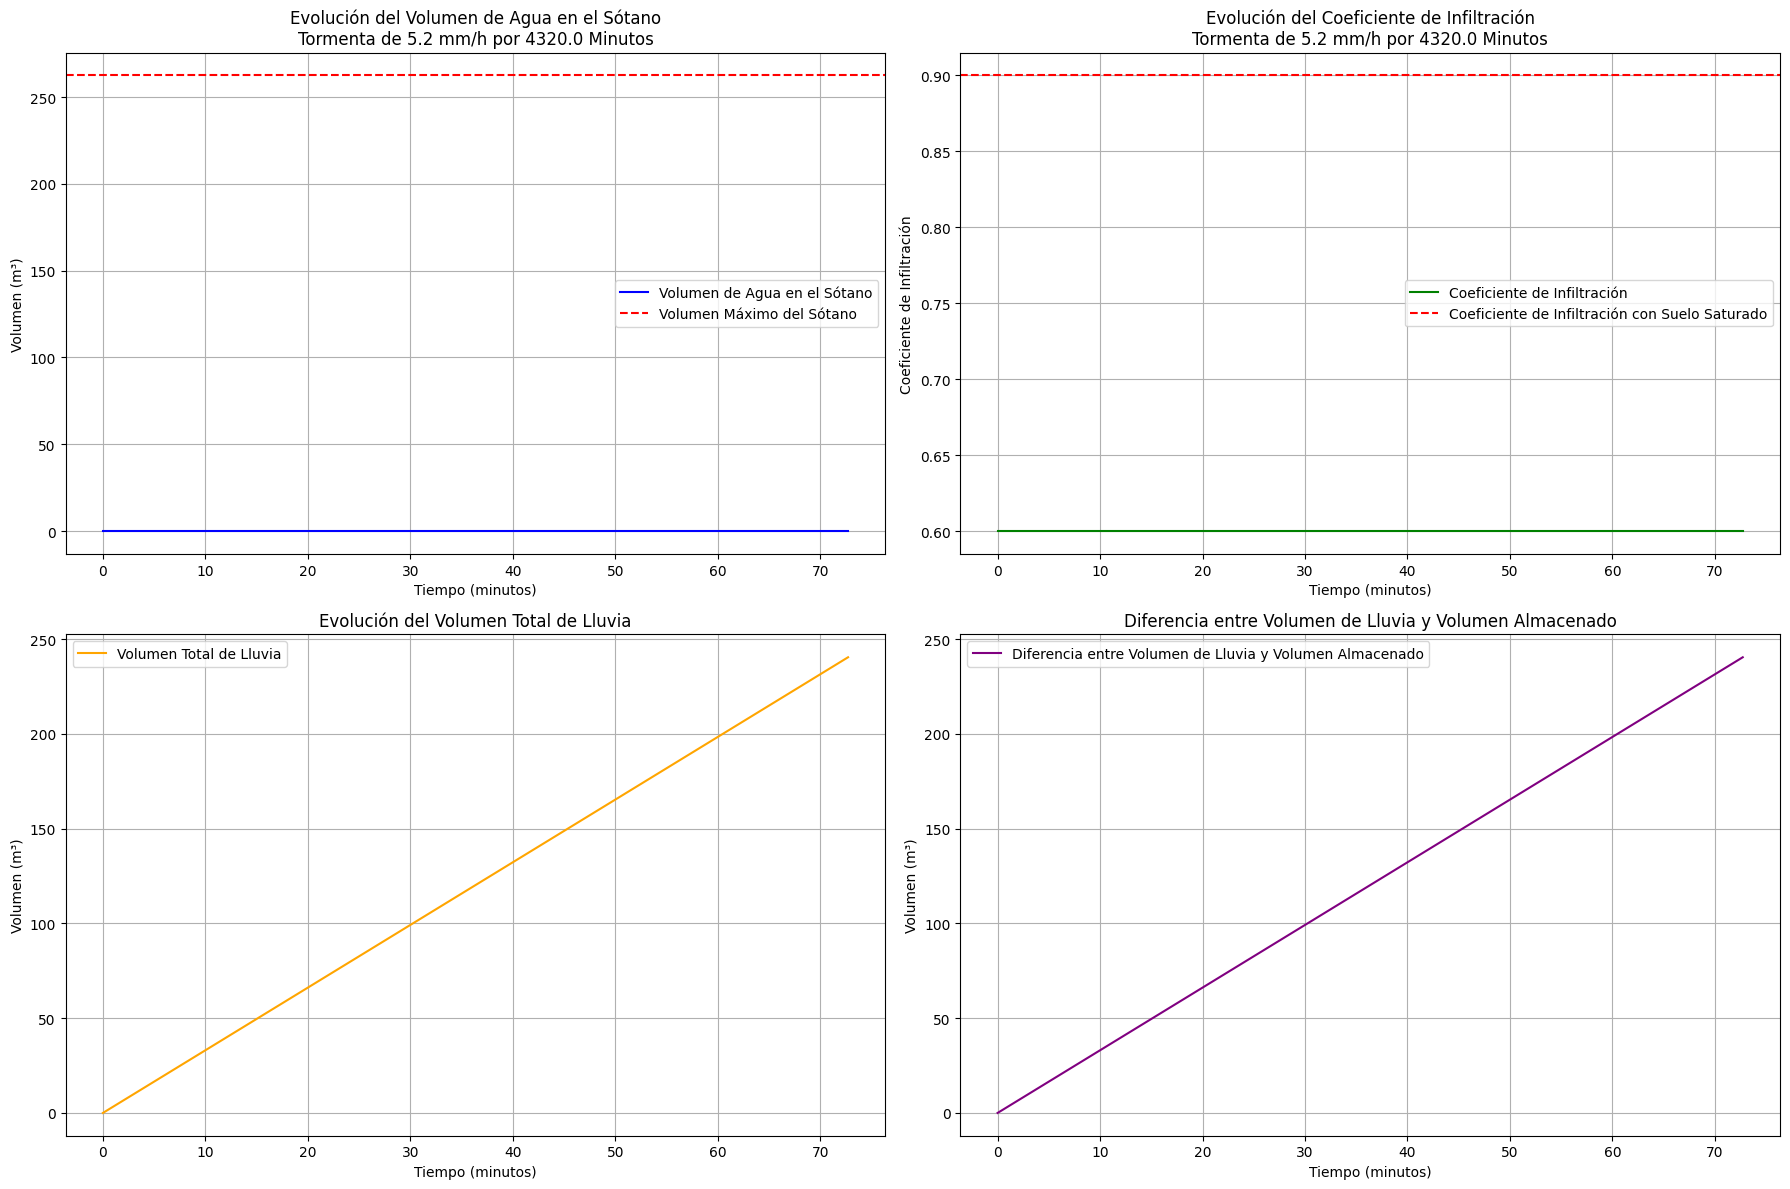

In [40]:
import matplotlib.pyplot as plt

for storm_duration, storm_intensity, volumes, infiltrations, d_time in storms_history:
    times = [i * d_time for i in range(len(volumes))]
    total_rainfall_volume = [d_time * storm_intensity * A_TERR * i for i in range(len(volumes))]
    volume_difference = [total_rainfall_volume[i] - volumes[i] for i in range(len(volumes))]

    plt.figure(figsize=(18, 12))  

    # Evolución del Volumen de Agua en el Sótano
    plt.subplot(2, 2, 1)
    plt.plot(times, volumes, label='Volumen de Agua en el Sótano', color='blue')
    plt.axhline(y=V_SOT, color='r', linestyle='--', label='Volumen Máximo del Sótano')
    plt.xlabel('Tiempo (minutos)')
    plt.ylabel('Volumen (m³)')
    plt.title(f'Evolución del Volumen de Agua en el Sótano\nTormenta de {storm_intensity*1000} mm/h por {storm_duration*60} Minutos')
    plt.legend()
    plt.grid(True)

    # Evolución del Coeficiente de Infiltración
    plt.subplot(2, 2, 2)
    plt.plot(times, infiltrations, label='Coeficiente de Infiltración', color='green')
    plt.axhline(y=C_SAT, color='r', linestyle='--', label='Coeficiente de Infiltración con Suelo Saturado')
    plt.xlabel('Tiempo (minutos)')
    plt.ylabel('Coeficiente de Infiltración')
    plt.title(f'Evolución del Coeficiente de Infiltración\nTormenta de {storm_intensity*1000} mm/h por {storm_duration*60} Minutos')
    plt.legend()
    plt.grid(True)

    # Evolución del Volumen Total de Lluvia
    plt.subplot(2, 2, 3)
    plt.plot(times, total_rainfall_volume, label='Volumen Total de Lluvia', color='orange')
    plt.xlabel('Tiempo (minutos)')
    plt.ylabel('Volumen (m³)')
    plt.title('Evolución del Volumen Total de Lluvia')
    plt.legend()
    plt.grid(True)

    # Diferencia entre Volumen de Lluvia y Volumen Almacenado
    plt.subplot(2, 2, 4)
    plt.plot(times, volume_difference, label='Diferencia entre Volumen de Lluvia y Volumen Almacenado', color='purple')
    plt.xlabel('Tiempo (minutos)')
    plt.ylabel('Volumen (m³)')
    plt.title('Diferencia entre Volumen de Lluvia y Volumen Almacenado')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## B 

Dimensionamiento de la bomba. Redimensionar la bomba adoptando un nuevo $Q_{max}$
para que la altura de agua sobre el piso del sótano no exceda los 0,25m para ninguna de las precipitaciones de la tabla.

In [21]:
# Q_MAX inicial 
Q_MAX = 1

# incremento de Q_MAX en cada paso
increment = 1

# Maxima altura de agua en el sotano
max_water_height = 0.25

while True:
    #print(f"Trying with Q_MAX = {Q_MAX}")

    storms_history = []

    for storm_duration, storm_intensity in storms:
        #print(f"Starting storm with {storm_intensity*1000} mm/h for {storm_duration*60} min")

        volumes = []
        infiltrations = []

        time = 0

        volume = 0
        volumes.append(volume)

        infiltration = C_0
        infiltrations.append(infiltration)

        d_time = storm_duration / 100

        while time < storm_duration:
            volume = volume + d_time * d_volume(time, volume, infiltration, storm_intensity)
            infiltration = infiltration + d_time * d_infiltration(time, volume, infiltration)
            volumes.append(volume)
            infiltrations.append(infiltration)
            time += d_time

            water_height = f_altura_agua_h(volume, A_SOT)

            if water_height > max_water_height:
                break

        if water_height > max_water_height:
            break

        #print(f"Storm finish and sotane has {round(volume,2)} m3")

        while volume > 0:
            volume = volume + d_time * d_volume(time, volume, infiltration, 0)
            infiltration = infiltration + d_time * d_infiltration(time, volume, infiltration)
            volumes.append(volume)
            infiltrations.append(infiltration)
            time += d_time

        #print(f"Empyting sotane after {round(time*60,2)} min")
        #print("")

        storms_history.append((storm_duration, storm_intensity, volumes, infiltrations, d_time))

    if water_height <= max_water_height:
        break

    Q_MAX += increment

print(f"Found Q_MAX = {Q_MAX} that ensures the water height never exceeds {max_water_height}m for all storms")

Found Q_MAX = 33 that ensures the water height never exceeds 0.25m for all storms
